# Adidas Data Science Challenge
This Notebook covers:
1. Definition of **business problem** - Demand forecasting
2. **Analysis of data** provided by adidas (synthetic data of sales and article attributes)
3. **Preparation of data** for regression modelling (feature engineering and encoding)
4. **The Model**
    1. Model specification and training
    2. Hyperparameter optimisation
    3. Model diagnostics
        1. Improving initial model for large jumps using temporal features 
        2. Discussion on possible further improvements

## 1. Business problem
In this example project we focus on the standard problem of **Demand forecasting**. 

Specifically, we want to be able to **predict the sales of an article based on its characteristics at a given time** (narrowed down to a retail week). This allows for better utilization of inventory space (since we don't waste resources on items with low turnover) and can be used for planning production figures (for example to avoid the risk of stock outs). 

## 2. Data Analysis
Here we will go over the data that was provided by adidas:
1. Transactional data of adidas stores - `sales.txt`
2. Attribute data of the sold articles - `article_attributes.txt`

The analysis is mainly focused on determining:
1. What is the quality of the data?
    1. Are there mssing values for any of the features?
    2. Do all articles have sales data and vice versa?
    3. Are the features properly encoded?
    4. Which features are categorical and what is their cardinality?
2. Do we have the necessary features for demand forecasting?
    1. How long are the time series available?
    2. Are there missing weeks in the time series? (globally or for individual articles/countries)
    3. Do the sales numbers show expected trends (seasonal factors, peaks during end of season sales at adidas)


In [1]:
# Import basic python libraries for data analysis and visualization
import os 
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data on articles and weekly sales information
articles_df = pd.read_csv("article_attributes.txt", sep = ";")
sales_df = pd.read_csv("sales.txt", sep = ";")

# Print the number of articles and sales information
print("Number of articles:", len(articles_df))
print("Sales information (Article, Country, Week):", len(sales_df))

Number of articles: 476
Sales information (Article, Country, Week): 81426


In [3]:
# Checking if all articles have sales information and vice versa
print("Articles with no sales info: ", set(articles_df.article) - set(sales_df.article))
print("Articles with sales info, but no attributes: ",set(sales_df.article) - set(articles_df.article))

Articles with no sales info:  set()
Articles with sales info, but no attributes:  {'IO7646'}


In [4]:
# Checking for missing values in both dataframes
print("Articles missing values:\n", articles_df.isna().sum())
print("Sales missing values:\n", sales_df.isna().sum())

Articles missing values:
 article           0
productgroup      0
category          0
cost              0
style             0
sizes             0
gender            0
rgb_r_main_col    0
rgb_g_main_col    0
rgb_b_main_col    0
rgb_r_sec_col     0
rgb_g_sec_col     0
rgb_b_sec_col     0
dtype: int64
Sales missing values:
 country          0
article          0
sales            0
regular_price    0
current_price    0
ratio            0
retailweek       0
promo1           0
promo2           0
dtype: int64


In [5]:
# Looking at cardinality of categorical columns for both dataframes
categorical_columns = articles_df.select_dtypes(include=['object']).columns.sort_values()
print("Cardinality of categorical columns in articles_df:")
for column in categorical_columns:
    cardinality = articles_df[column].nunique()
    print(f"{column}: {cardinality}")

categorical_columns = sales_df.select_dtypes(include=['object']).columns.sort_values()
print("Cardinality of categorical columns in sales_df:")
for column in categorical_columns:
    cardinality = sales_df[column].nunique()
    print(f"{column}: {cardinality}")

Cardinality of categorical columns in articles_df:
article: 476
category: 21
gender: 4
productgroup: 6
sizes: 8
style: 3
Cardinality of categorical columns in sales_df:
article: 477
country: 3
retailweek: 123


C:\Users\Korisnik\AppData\Local\Temp\ipykernel_16748\1546119339.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


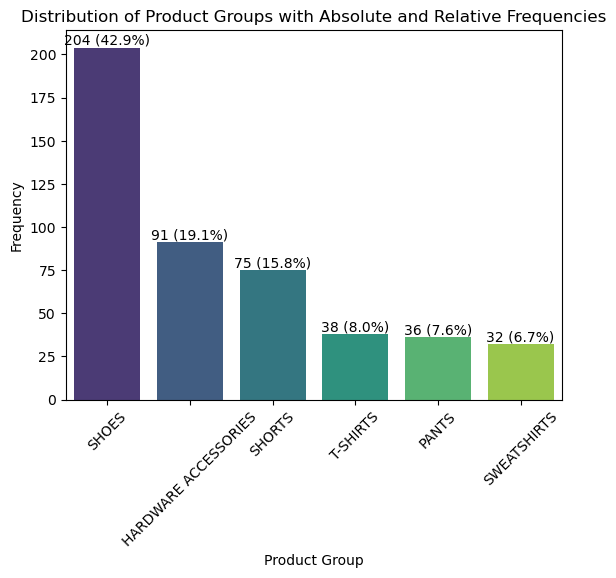

In [6]:
# Visualize the distribution of product groups
# Calculate counts
counts = articles_df['productgroup'].value_counts()
total = len(articles_df)

# Create the bar plot
sns.barplot(x=counts.index, y=counts.values, palette='viridis')

# Annotate bars with the absolute and relative value
for i, count in enumerate(counts):
    plt.text(i, count, f'{count} ({count/total:.1%})', ha='center', va='bottom')

plt.title('Distribution of Product Groups with Absolute and Relative Frequencies')
plt.xlabel('Product Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate labels if necessary
plt.show()

C:\Users\Korisnik\AppData\Local\Temp\ipykernel_16748\3904404187.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


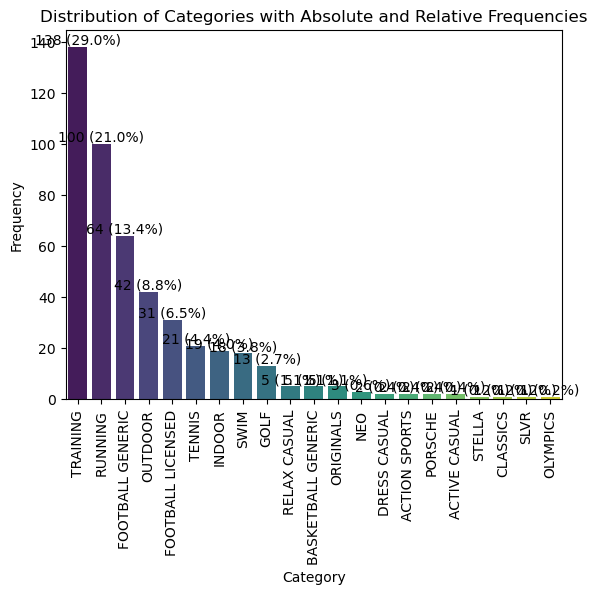

In [7]:
# Visualize the distribution of categories
# Calculate counts
counts = articles_df['category'].value_counts()
total = len(articles_df)

# Create the bar plot
sns.barplot(x=counts.index, y=counts.values, palette='viridis')

# Annotate bars with the absolute and relative value
for i, count in enumerate(counts):
    plt.text(i, count, f'{count} ({count/total:.1%})', ha='center', va='bottom')

plt.title('Distribution of Categories with Absolute and Relative Frequencies')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate labels if necessary
plt.show()

In [8]:
# Check if column "article" is primary key
print("Article is unique id: ", len(articles_df) == articles_df.article.nunique())
# Check if sales has any information on missing articles
print("Sales and article have the same articles:", set(articles_df.article) == set(sales_df.article))

Article is unique id:  True
Sales and article have the same articles: False


In [9]:
# Example rows of articles_df
articles_df.head(5)

,article,productgroup,category,cost,style,sizes,gender,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col
0,OC6355,SHOES,TRAINING,13.29,slim,"xxs,xs,s,m,l,xl,xxl",women,205,104,57,255,187,255
1,AP5568,SHORTS,TRAINING,2.29,regular,"xxs,xs,s,m,l,xl,xxl",women,188,238,104,255,187,255
2,CB8861,HARDWARE ACCESSORIES,GOLF,1.70,regular,"xxs,xs,s,m,l,xl,xxl",women,205,173,0,255,187,255
3,LI3529,SHOES,RUNNING,9.00,regular,"xxs,xs,s,m,l,xl,xxl",kids,205,140,149,164,211,238
4,GG8661,SHOES,RELAX CASUAL,9.60,regular,"xxs,xs,s,m,l,xl,xxl",women,138,43,226,164,211,238


In [10]:
# Example rows of sales_df
sales_df.head(5)

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0


In [11]:
# Check initial colum types in both dataframes
print("Columns in articles data: ")
for column in articles_df.columns:
    print(column, type(articles_df[column][0]))

print("Columns in sales data: ")
for column in sales_df.columns:
    print(column, type(sales_df[column][0]))

Columns in articles data: 
article <class 'str'>
productgroup <class 'str'>
category <class 'str'>
cost <class 'numpy.float64'>
style <class 'str'>
sizes <class 'str'>
gender <class 'str'>
rgb_r_main_col <class 'numpy.int64'>
rgb_g_main_col <class 'numpy.int64'>
rgb_b_main_col <class 'numpy.int64'>
rgb_r_sec_col <class 'numpy.int64'>
rgb_g_sec_col <class 'numpy.int64'>
rgb_b_sec_col <class 'numpy.int64'>
Columns in sales data: 
country <class 'str'>
article <class 'str'>
sales <class 'numpy.int64'>
regular_price <class 'numpy.float64'>
current_price <class 'numpy.float64'>
ratio <class 'numpy.float64'>
retailweek <class 'str'>
promo1 <class 'numpy.int64'>
promo2 <class 'numpy.int64'>


## 3. Data Preparation
Given the feature types that we have available we decided to do the following:
1. Extract the temporal information 
    - Convert string representations to Date
    - Extract the month, year (seasonal effects) as well as total elapsed_weeks to have a natural feature for constructing a timeline
2. Perform scaling of numeric features with known ranges (specifically RGB values that are between 0 and 255)
3. Peform one-hot encoding for the categorical features with low cardinality 
    - We note that this step is not really necessary after the final model choice (CatBoost regressor), however in general it does allow us to use the same data as input for standard regression models
4. Perform encoding for ordinal features such as 'size' and 'style' that have a natural progression


In [12]:
# Converting temporal information to datetime
sales_df['retailweek'] = pd.to_datetime(sales_df['retailweek'])

# Extract month and year from the retailweek column
sales_df['month'] = sales_df['retailweek'].dt.month
sales_df['year'] = sales_df['retailweek'].dt.year

# Extract week of year and elapsed days since the first date in the data
sales_df['week_of_year'] = sales_df['retailweek'].dt.isocalendar().week
sales_df['elapsed_weeks'] = (sales_df['retailweek'] - sales_df['retailweek'].min()).dt.days // 7

# Sort the data by article and retailweek
sales_df = sales_df.sort_values(by = ['article', 'retailweek'])

# Print number of different dates per article 
print(sales_df.groupby('article')['retailweek'].nunique().value_counts())

# Print first and last date available for each article
print(sales_df.groupby('article')['retailweek'].agg(['min', 'max']))
    
# Check if first and last date are the same for each article
print(sales_df.groupby('article')['retailweek'].agg(['min', 'max']).nunique())

retailweek
123    477
Name: count, dtype: int64
               min        max
article                      
AA1821  2014-12-28 2017-04-30
AA7884  2014-12-28 2017-04-30
AA8941  2014-12-28 2017-04-30
AC7347  2014-12-28 2017-04-30
AD9697  2014-12-28 2017-04-30
...            ...        ...
ZV2187  2014-12-28 2017-04-30
ZW6694  2014-12-28 2017-04-30
ZX2294  2014-12-28 2017-04-30
ZX8794  2014-12-28 2017-04-30
ZZ2466  2014-12-28 2017-04-30

[477 rows x 2 columns]
min    1
max    1
dtype: int64


<Axes: xlabel='retailweek'>

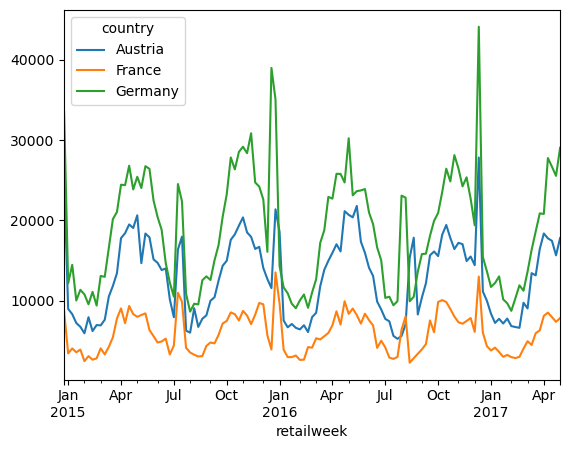

In [13]:
# Visualize total sales over time for each country in a single plot
# We notice similar seasonal trends across countries
sales_df.groupby(['retailweek', 'country'])['sales'].sum().unstack().plot()

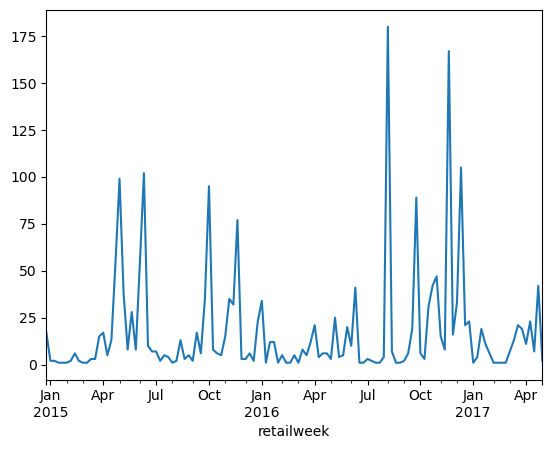

In [14]:
# Visualise the single timeline available for the missing article 
missing_df = sales_df[sales_df["article"]=="IO7646"]
missing_df.groupby('retailweek')['sales'].sum().plot()
plt.show()

In [15]:
# For articles_df we check the number of unique values in each categorical column
categorical_columns = ['article', 'productgroup', 'category', 'style', 'sizes', 'gender']
for col in categorical_columns:
    print(f"{col} has {articles_df[col].nunique()} unique values")

article has 476 unique values
productgroup has 6 unique values
category has 21 unique values
style has 3 unique values
sizes has 8 unique values
gender has 4 unique values


In [16]:
articles_df["style"].value_counts()

style
slim       169
regular    161
wide       146
Name: count, dtype: int64

In [17]:
# Split the 'sizes' string into a list, then take the first and last elements as min and max size
articles_df['min_size'] = articles_df['sizes'].apply(lambda x: x.split(',')[0])
articles_df['max_size'] = articles_df['sizes'].apply(lambda x: x.split(',')[-1])

# Map sizes to a numeric scale
size_mapping = {'xxs': 1, 'xs': 2, 's': 3, 'm': 4, 'l': 5, 'xl': 6, 'xxl': 7}
articles_df['min_size_numeric'] = articles_df['min_size'].map(size_mapping)
articles_df['max_size_numeric'] = articles_df['max_size'].map(size_mapping)

# Map style of article to a numeric scale
style_mapping = {'slim': 1, 'regular': 2, 'wide': 3}
articles_df['style_numeric'] = articles_df['style'].map(style_mapping)

# Check the first few rows to verify
print(articles_df[['sizes', 'min_size', 'max_size', 'min_size_numeric', 'max_size_numeric', 'style_numeric']].tail())

                   sizes min_size max_size  min_size_numeric  \
471  xxs,xs,s,m,l,xl,xxl      xxs      xxl                 1   
472             s,m,l,xl        s       xl                 3   
473  xxs,xs,s,m,l,xl,xxl      xxs      xxl                 1   
474  xxs,xs,s,m,l,xl,xxl      xxs      xxl                 1   
475  xxs,xs,s,m,l,xl,xxl      xxs      xxl                 1   

     max_size_numeric  style_numeric  
471                 7              2  
472                 6              3  
473                 7              2  
474                 7              3  
475                 7              1  


In [18]:
# Calculate the ratio as current_price/regular_price
calculated_ratio = sales_df['current_price'] / sales_df['regular_price']

# Check if calculated_ratio is approximately equal to the 'ratio' column within a margin of 1e-3
is_approx_equal = (abs(calculated_ratio - sales_df['ratio']) <= 1e-3).all()

print(f"Is the 'ratio' column approximately equal to current_price/regular_price? {is_approx_equal}")

if is_approx_equal:
    sales_df['discount_percentage'] = (1 - sales_df['ratio'])
    # Optionally drop the 'ratio' column if it's redundant
    sales_df.drop(columns=['ratio'], inplace=True)

Is the 'ratio' column approximately equal to current_price/regular_price? True


In [19]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Convert RGB columns to 0-1 scale
rgb_columns = ['rgb_r_main_col', 'rgb_g_main_col', 'rgb_b_main_col', 'rgb_r_sec_col', 'rgb_g_sec_col', 'rgb_b_sec_col']
articles_df[rgb_columns] = articles_df[rgb_columns].astype(float)

# Scale RGB features to 0-1 range
scaler = MinMaxScaler()
articles_df[rgb_columns] = scaler.fit_transform(articles_df[rgb_columns])

# One-hot encoding for 'productgroup' and 'gender'
articles_df = pd.get_dummies(articles_df, columns=['productgroup', 'gender'])

# One-hot encoding for 'country'
contry_one_hot_encoded = pd.get_dummies(sales_df['country'], prefix='country')
sales_df = pd.concat([sales_df, contry_one_hot_encoded], axis=1)


In [20]:
# Features after encoding and scaling
articles_df.head(5)

,article,category,cost,style,sizes,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,...,productgroup_HARDWARE ACCESSORIES,productgroup_PANTS,productgroup_SHOES,productgroup_SHORTS,productgroup_SWEATSHIRTS,productgroup_T-SHIRTS,gender_kids,gender_men,gender_unisex,gender_women
0,OC6355,TRAINING,13.29,slim,"xxs,xs,s,m,l,xl,xxl",0.803922,0.383673,0.223529,1.000000,0.722449,...,False,False,True,False,False,False,False,False,False,True
1,AP5568,TRAINING,2.29,regular,"xxs,xs,s,m,l,xl,xxl",0.737255,0.930612,0.407843,1.000000,0.722449,...,False,False,False,True,False,False,False,False,False,True
2,CB8861,GOLF,1.70,regular,"xxs,xs,s,m,l,xl,xxl",0.803922,0.665306,0.000000,1.000000,0.722449,...,True,False,False,False,False,False,False,False,False,True
3,LI3529,RUNNING,9.00,regular,"xxs,xs,s,m,l,xl,xxl",0.803922,0.530612,0.584314,0.643137,0.820408,...,False,False,True,False,False,False,True,False,False,False
4,GG8661,RELAX CASUAL,9.60,regular,"xxs,xs,s,m,l,xl,xxl",0.541176,0.134694,0.886275,0.643137,0.820408,...,False,False,True,False,False,False,False,False,False,True


In [21]:
# Merging the sales and articles data on the 'article' column
merged_df = pd.merge(sales_df, articles_df, on = 'article', how = 'inner')
print("Merged data:", len(merged_df))
merged_df.iloc[0]
#merged_df.head(5)

Merged data: 81303


country                                          Germany
article                                           AA1821
sales                                                 62
regular_price                                      31.95
current_price                                      25.95
retailweek                           2014-12-28 00:00:00
promo1                                                 1
promo2                                                 0
month                                                 12
year                                                2014
week_of_year                                          52
elapsed_weeks                                          0
discount_percentage                             0.187793
country_Austria                                    False
country_France                                     False
country_Germany                                     True
category                                         RUNNING
cost                           

In [22]:
merged_df.columns

Index(['country', 'article', 'sales', 'regular_price', 'current_price',
       'retailweek', 'promo1', 'promo2', 'month', 'year', 'week_of_year',
       'elapsed_weeks', 'discount_percentage', 'country_Austria',
       'country_France', 'country_Germany', 'category', 'cost', 'style',
       'sizes', 'rgb_r_main_col', 'rgb_g_main_col', 'rgb_b_main_col',
       'rgb_r_sec_col', 'rgb_g_sec_col', 'rgb_b_sec_col', 'min_size',
       'max_size', 'min_size_numeric', 'max_size_numeric', 'style_numeric',
       'productgroup_HARDWARE ACCESSORIES', 'productgroup_PANTS',
       'productgroup_SHOES', 'productgroup_SHORTS', 'productgroup_SWEATSHIRTS',
       'productgroup_T-SHIRTS', 'gender_kids', 'gender_men', 'gender_unisex',
       'gender_women'],
      dtype='object')

## 4. The regression model
The chosen regression model for predicting sales is the `CatBoost` Regressor. The reason for choosing this model are as follows:
1. The model can natively use categorical features, even with high cardinality (this is relevant due to the 21 categories that have a skewed distribution). It is also able to handle missing values which would allow for easier integration of additional training data.
2. The model can be easily trained with the dataset size that we are working with (this allows for relatively fast hyperparameter optimisation)
3. The model is based on gradient boosting, which has been shown to achieve good accuracy (given the way that each additional model works on eliminating the errors of the previous one).

The steps that we take are as follows:
1. Perform Hyperaparameter optimisation on the `learning_rate`, `depth` and `iterations`
    - We use RMSE as the objective of the HPO loop - we want to prioritize having smaller individual erros as we want good predictions on the level of individual articles and not the entire offering.
    - We use a TimeSeriesSplit instead of a regular CV split to see how well a model can generalise when encountering new time points
2. Retrain the model on the full dataset using the best HP configuration
3. Examine how the predictions compare to the ground truth

After the initial models predictions are visualised we notice that the model is having particular difficulty in predicting extreme jumps (where the weekly sales are >300% higher than the average for an article). We show that the model can be further improved with additional feature engineering. As a proof of concept we expand the dataset with:
- Lagged features - We add the sales for the past 3 weeks to each row 
- Moving average - We add the average of the past 3 weeks to each row
Additional lagged features or longer time windows can of course further improve the results. (for example knowing if the previous few weeks had any promotions active combined with the features promo1 and promo2 can capture the fact that we are creating a sense of urgency at a given week).

We visualise the predictions of the initial model as well as the model using these new features at the end of the notebook.

#### HP Optimisation
- If you wish to rerun the HPO procedure from scratch for CatBoost please set retrain to True. Otherwise the best model and the performance of different configurations will be loaded from existing files.

In [23]:
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import time

# Removing redundant columns and target columns (min and max now have numeric versions, sizes is redundant, regular_price is redundant, style is redundant)
X = merged_df.drop(['min_size', 'max_size', 'sizes','regular_price','style','country','sales', 'article', 'retailweek',], axis=1)
y = merged_df['sales']

# Define the TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Space of hyperparameters to optimize
space = [
    Real(0.01, 0.3, name='learning_rate'),
    Integer(3, 10, name='depth'),
    Integer(100, 1000, name='iterations')
]

# Wrap the objective function to facilitate cross-validation within each BO iteration
@use_named_args(space)
def objective_function(learning_rate, depth, iterations):
    start_time = time.time()
    model = CatBoostRegressor(
        learning_rate=learning_rate,
        depth=depth,
        iterations=iterations,
        verbose=False
    )

    # Use TimeSeriesSplit for cross-validation within the objective function
    rmse_scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train, cat_features=np.where(X_train.dtypes == 'object')[0])
        predictions = model.predict(X_test)
        rmse_score = np.sqrt(mean_squared_error(y_test, predictions))
        rmse_scores.append(rmse_score)

    training_time = time.time() - start_time
    avg_rmse = np.mean(rmse_scores)

    bo_results.append({
        'learning_rate': learning_rate,
        'depth': depth,
        'iterations': iterations,
        'average_rmse': avg_rmse,
        'training_time': training_time
    })

    return avg_rmse  # Return average RMSE

# Define a callback function to print the progress
def progress_callback(res):
    print("Iteration No: {}, current best score: {:.4f}".format(len(res.func_vals), res.fun))

In [24]:
bo_results = []
retrain = False
# Perform Bayesian Optimization
if retrain:
    res_gp = gp_minimize(objective_function,
                        space, 
                        n_calls = 40, 
                        n_initial_points= 8,
                        callback = [progress_callback], 
                        random_state = 0)

    # Output the optimization results
    print("Optimization completed.")
    print("Best score=%.4f" % res_gp.fun)
    print("""Best parameters:
    - learning_rate=%.3f
    - depth=%d
    - iterations=%d""" % (res_gp.x[0], res_gp.x[1], res_gp.x[2]))
    bo_df = pd.DataFrame(bo_results)
    bo_df.to_csv("bo_results.csv", index=False)
else:
    bo_df = pd.read_csv("bo_results.csv")

bo_df.head()

,learning_rate,depth,iterations,average_rmse,training_time
0,0.181925,9,872,89.139699,334.519987
1,0.255703,7,446,88.245983,124.688263
2,0.096285,3,345,85.390039,48.779536
3,0.148523,9,532,87.624216,228.248344
4,0.123908,9,404,86.801313,152.987867


In [25]:
model_save_path = 'best_catboost_model.cbm'
# Retrain the model with the best hyperparameters on the full dataset or read the previous best model
if retrain:
    # Extract the best hyperparameters from the optimization results
    best_learning_rate = res_gp.x[0]
    best_depth = res_gp.x[1]
    best_iterations = res_gp.x[2]

    # Retrain the model with the best parameters on the full dataset
    best_model = CatBoostRegressor(
        learning_rate=best_learning_rate,
        depth=best_depth,
        iterations=best_iterations,
        verbose=False
    )

    # Fit the model
    best_model.fit(X, y, cat_features=np.where(X.dtypes == 'object')[0])
    # Save best performing model
    best_model.save_model(model_save_path)
else:
    if os.path.isfile(model_save_path):
        best_model = CatBoostRegressor()
        best_model.load_model(model_save_path)
    else:
        raise FileNotFoundError("The model file does not exist. Please retrain the model by setting retrain to True.")

In [26]:
styled_df = bo_df.style.highlight_max(subset=['average_rmse'], color='red').highlight_min(subset=['average_rmse'], color='green')
styled_df

,learning_rate,depth,iterations,average_rmse,training_time
0,0.181925,9,872,89.139699,334.519987
1,0.255703,7,446,88.245983,124.688263
2,0.096285,3,345,85.390039,48.779536
3,0.148523,9,532,87.624216,228.248344
4,0.123908,9,404,86.801313,152.987867
5,0.197970,6,961,88.310392,227.847194
6,0.050702,9,526,85.779303,199.915950
7,0.242264,7,711,89.235363,196.589164
8,0.010000,4,411,84.653008,63.121961
9,0.010000,3,1000,84.720186,118.118667


In [27]:
# Predict the sales for each article in each conutry over time
predictions = best_model.predict(X)
# Add predictions to the DataFrame
merged_df['predicted_sales_catboost'] = predictions

rmse_score = np.sqrt(mean_squared_error(y, predictions))
print("Rmse score of best model: ", rmse_score)

Rmse score of best model:  83.11000063191213


### Evaluating the model
On Visual inspection it seems that there the articles vary greatly in the stability of their sales (for example article 'GG8661' has individual weeks where the sales numbers quadruple compared to the surrounding average, while article 'AP5568' has relatively minor jumps) 

The model seems to be having difficulty capturing extreme spikes and its predictions look closer to a smoothed out version of the original graph

Visualising predictions for article:  AP5568
No data available for Germany.


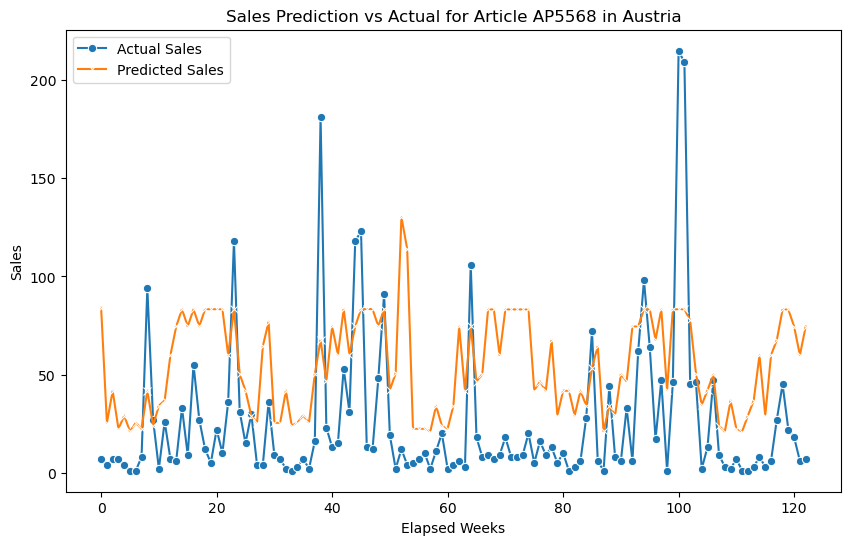

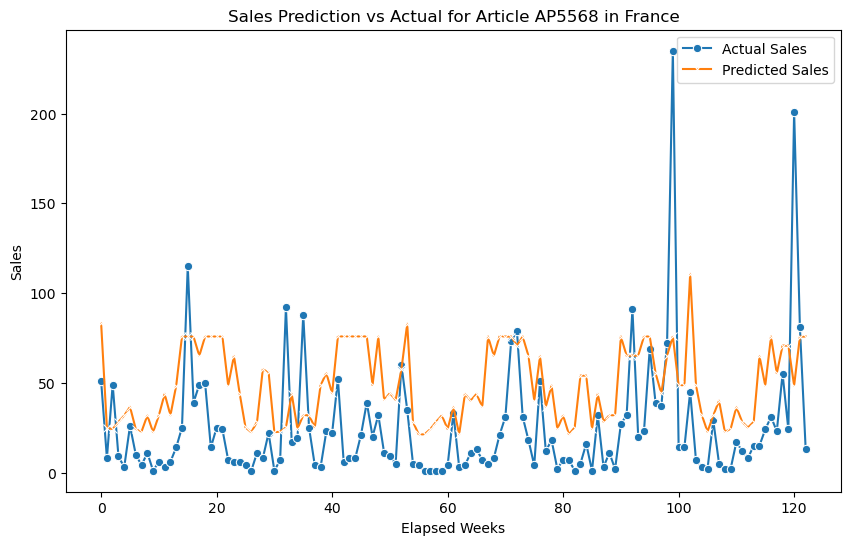

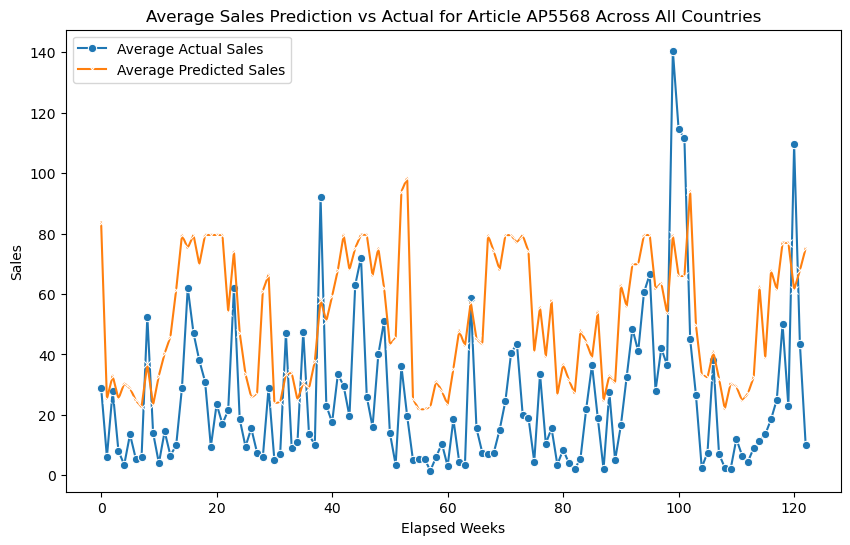

Visualising predictions for article:  GG8661


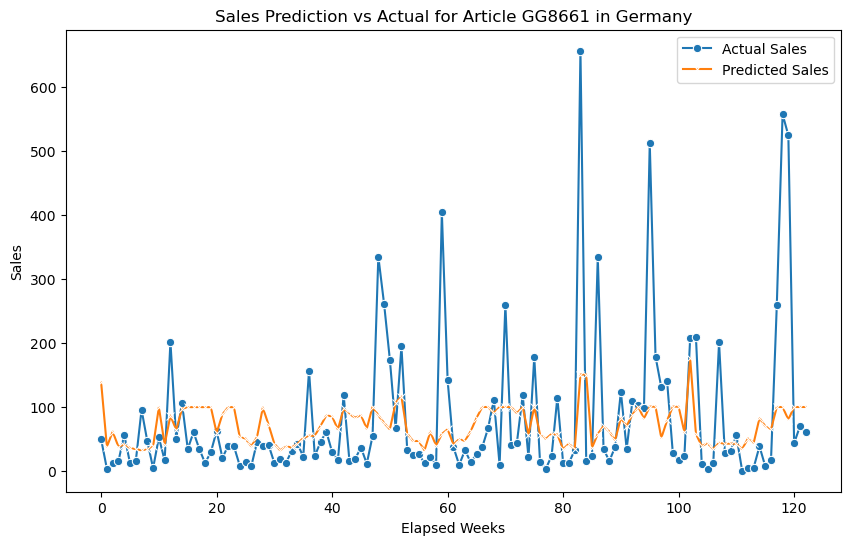

No data available for Austria.
No data available for France.


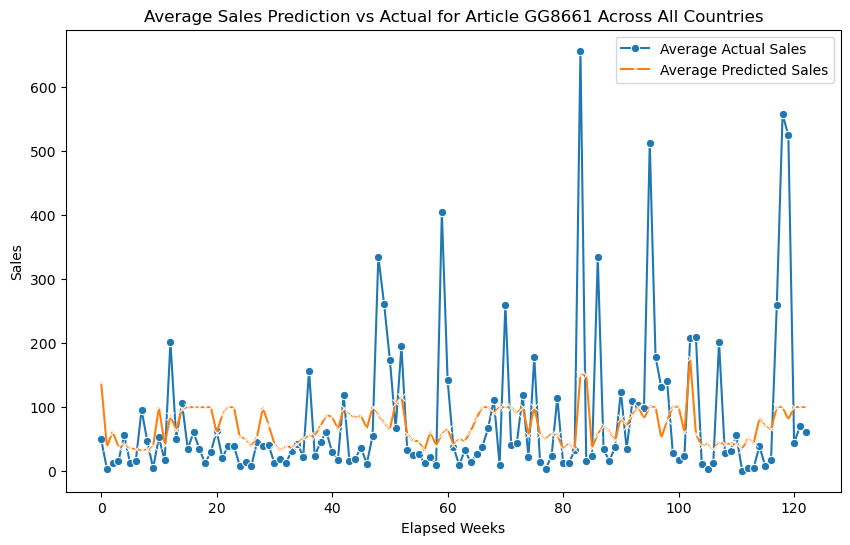

Visualising predictions for article:  LI3529


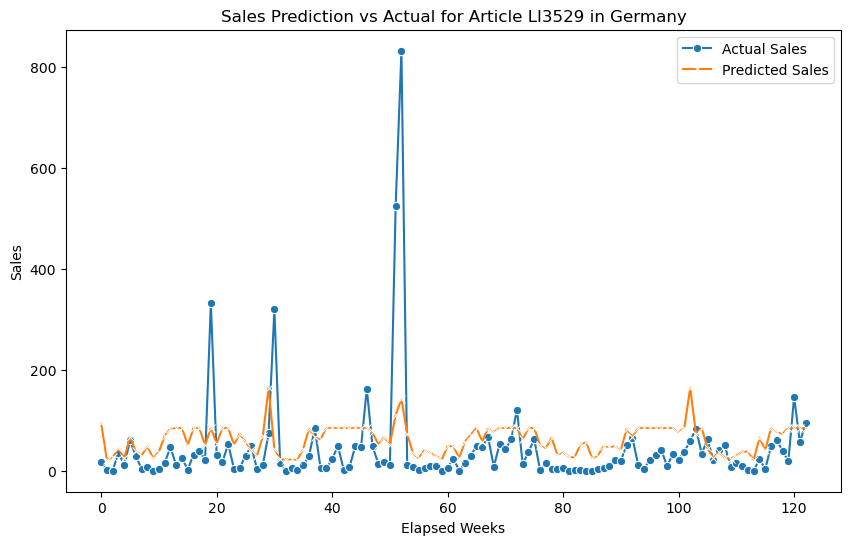

No data available for Austria.
No data available for France.


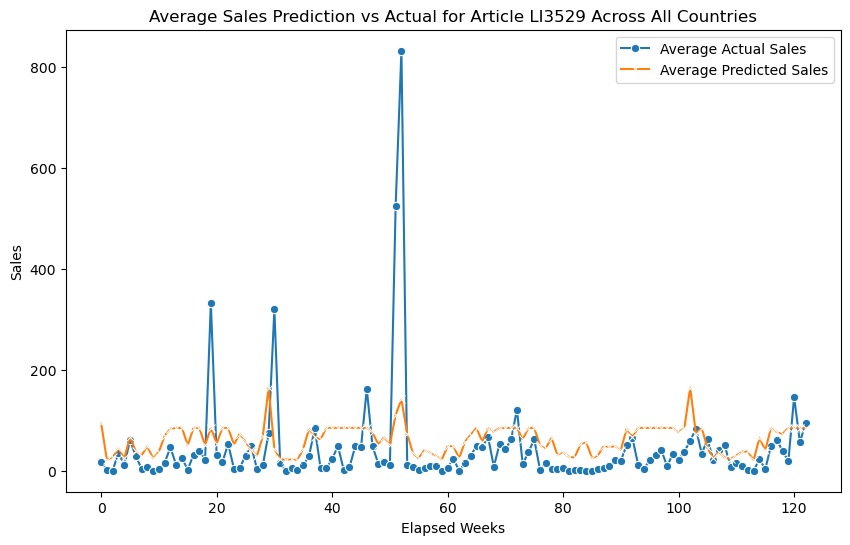

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Visualizing for a single article
article_id_list = ['AP5568','GG8661', 'LI3529']

for article_id in article_id_list:
    print("Visualising predictions for article: ", article_id)
    # Filter the DataFrame for this article
    article_df = merged_df[merged_df['article'] == article_id]

    # Plotting
    countries = ['Germany', 'Austria', 'France']  # List of countries

    for country in countries:
        # Filter for each country
        country_df = article_df[article_df[f'country_{country}'] == 1]
        
        if len(country_df) == 0:
            print(f"No data available for {country}.")
            continue

        plt.figure(figsize=(10, 6))
        sns.lineplot(data=country_df, x='elapsed_weeks', y='sales', label='Actual Sales', marker='o')
        sns.lineplot(data=country_df, x='elapsed_weeks', y='predicted_sales_catboost', label='Predicted Sales', marker='x')
        
        plt.title(f'Sales Prediction vs Actual for Article {article_id} in {country}')
        plt.xlabel('Elapsed Weeks')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()

    # Group by 'elapsed_weeks' and calculate mean sales and predicted sales
    average_sales_df = article_df.groupby('elapsed_weeks')[['sales', 'predicted_sales_catboost']].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=average_sales_df, x='elapsed_weeks', y='sales', label='Average Actual Sales', marker='o')
    sns.lineplot(data=average_sales_df, x='elapsed_weeks', y='predicted_sales_catboost', label='Average Predicted Sales', marker='x')

    plt.title(f'Average Sales Prediction vs Actual for Article {article_id} Across All Countries')
    plt.xlabel('Elapsed Weeks')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

In [29]:
merged_df.columns

Index(['country', 'article', 'sales', 'regular_price', 'current_price',
       'retailweek', 'promo1', 'promo2', 'month', 'year', 'week_of_year',
       'elapsed_weeks', 'discount_percentage', 'country_Austria',
       'country_France', 'country_Germany', 'category', 'cost', 'style',
       'sizes', 'rgb_r_main_col', 'rgb_g_main_col', 'rgb_b_main_col',
       'rgb_r_sec_col', 'rgb_g_sec_col', 'rgb_b_sec_col', 'min_size',
       'max_size', 'min_size_numeric', 'max_size_numeric', 'style_numeric',
       'productgroup_HARDWARE ACCESSORIES', 'productgroup_PANTS',
       'productgroup_SHOES', 'productgroup_SHORTS', 'productgroup_SWEATSHIRTS',
       'productgroup_T-SHIRTS', 'gender_kids', 'gender_men', 'gender_unisex',
       'gender_women', 'predicted_sales_catboost'],
      dtype='object')

#### Feature Engineering 
We add the lagged features as well as the rolling average for the past 3 weeks to each row (0 if we don't have any previous information)

In [30]:
# Ensure your DataFrame is sorted appropriately
merged_df.sort_values(by=['article', 'country', 'elapsed_weeks'], inplace=True)

# Create lagged features for sales
weeks_range = [1, 2, 3]
for lag in weeks_range:
    merged_df[f'sales_lag_{lag}'] = merged_df.groupby(['article', 'country'])['sales'].shift(lag)

# Handle missing values (NaNs) resulting from shifting
merged_df.fillna(0, inplace=True)  # Example approach; adjust based on your needs

In [31]:
# Define window size for rolling operation
window_size = len(weeks_range)

# Apply rolling mean; ensure you're grouping by 'article' and 'country'
merged_df[f'sales_rolling_mean_{window_size}'] = merged_df.groupby(['article', 'country'])['sales'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean().shift())

We again train the CatBoost regressor using the new features
- Note that we have opted to use the previous best configuration due to time constraints. Ideally, we would rerun the HPO procedure for the expanded feature set.

In [32]:
# Define X and y with the new features included in merged_df
X = merged_df.drop(['sales', 'article', 'retailweek', 'min_size', 'max_size', 'sizes', 'regular_price', 'style', 'country','predicted_sales_catboost'], axis=1)
y = merged_df['sales']

# Reinitialize the CatBoostRegressor with the saved best hyperparameters
best_params = {
    'learning_rate': 0.010000,
    'depth': 4,
    'iterations': 411
}

best_model = CatBoostRegressor(**best_params, verbose= False)

# Fit the model on the new features
best_model.fit(X, y, cat_features=np.where(X.dtypes == 'object')[0])

In [33]:
# Predict the sales for each article in each conutry over time
predictions = best_model.predict(X)
# Add predictions to the DataFrame
merged_df['predicted_sales_catboost_with_lag'] = predictions

rmse_score = np.sqrt(mean_squared_error(y, predictions))
print("Rmse score with lag features: ", rmse_score)

Rmse score with lag features:  79.51366012766914


Visualising predictions for article:  AP5568
No data available for Germany.


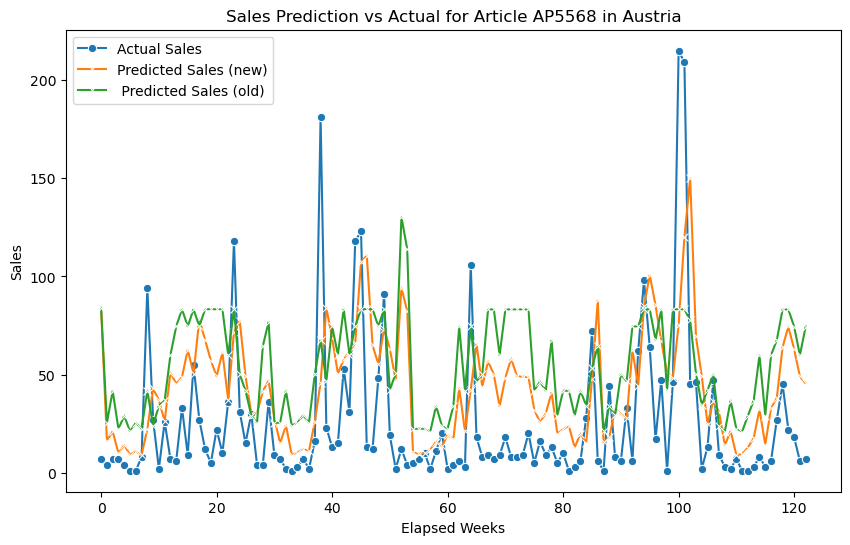

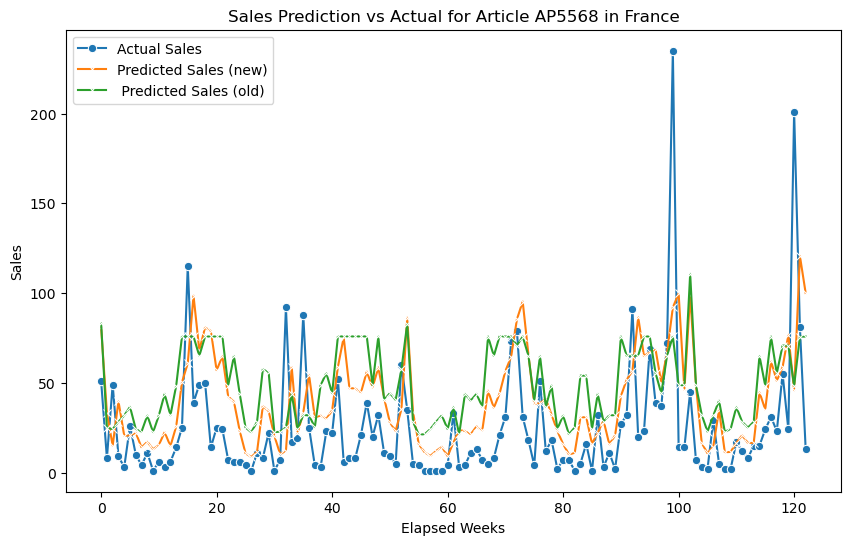

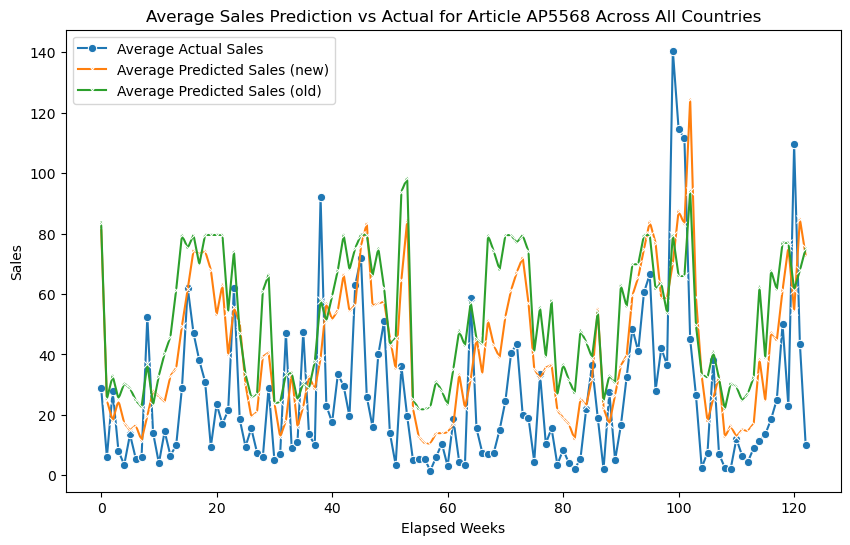

Visualising predictions for article:  GG8661


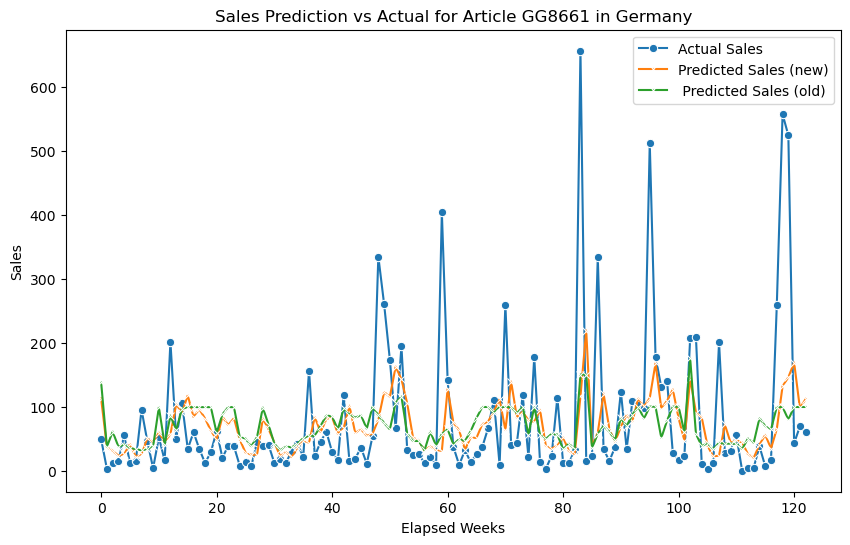

No data available for Austria.
No data available for France.


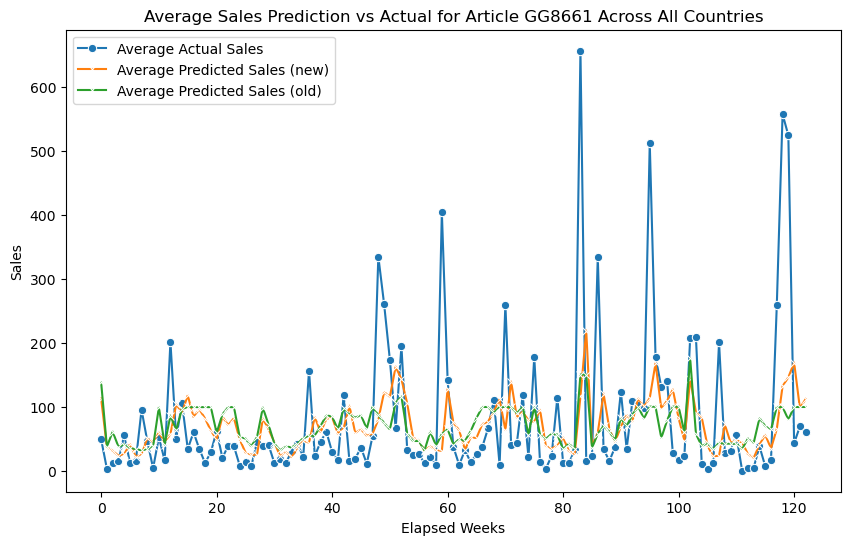

Visualising predictions for article:  LI3529


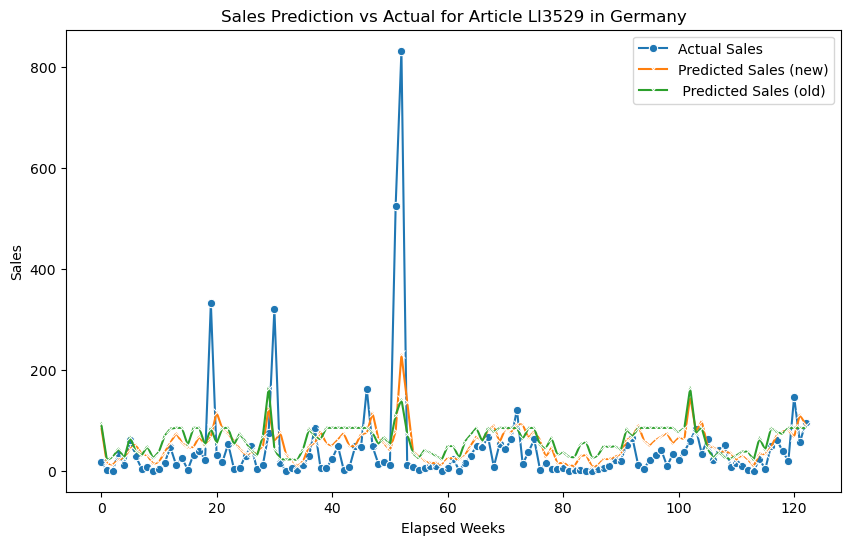

No data available for Austria.
No data available for France.


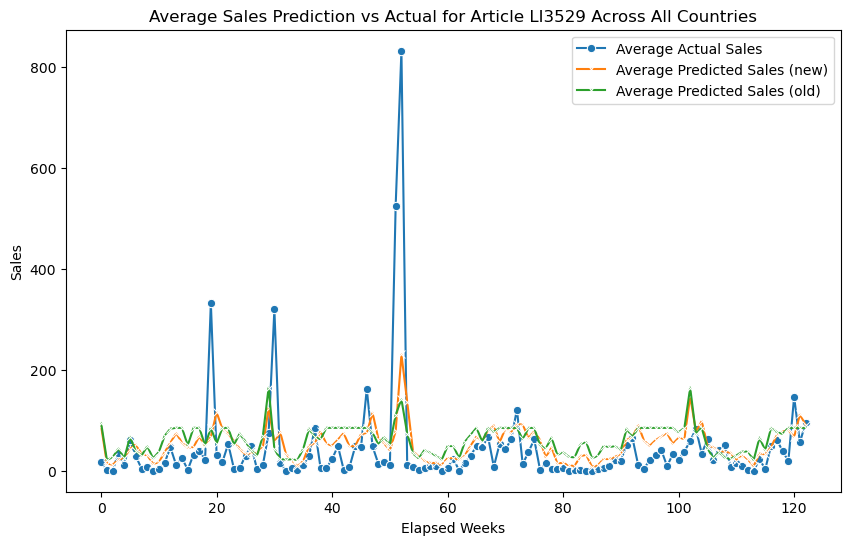

In [34]:
# Example: Visualizing for a single article
article_id_list = ['AP5568','GG8661', 'LI3529']

for article_id in article_id_list:
    print("Visualising predictions for article: ", article_id)
    # Filter the DataFrame for this article
    article_df = merged_df[merged_df['article'] == article_id]

    # Plotting
    countries = ['Germany', 'Austria', 'France']  # List of countries

    for country in countries:
        # Filter for each country
        country_df = article_df[article_df[f'country_{country}'] == 1]
        
        if len(country_df) == 0:
            print(f"No data available for {country}.")
            continue

        plt.figure(figsize=(10, 6))
        sns.lineplot(data=country_df, x='elapsed_weeks', y='sales', label='Actual Sales', marker='o')
        sns.lineplot(data=country_df, x='elapsed_weeks', y='predicted_sales_catboost_with_lag', label='Predicted Sales (new)', marker='x')
        sns.lineplot(data=country_df, x='elapsed_weeks', y='predicted_sales_catboost', label=' Predicted Sales (old)', marker='x')
        
        plt.title(f'Sales Prediction vs Actual for Article {article_id} in {country}')
        plt.xlabel('Elapsed Weeks')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()

    # Group by 'elapsed_weeks' and calculate mean sales and predicted sales
    average_sales_df = article_df.groupby('elapsed_weeks')[['sales', 'predicted_sales_catboost_with_lag', "predicted_sales_catboost"]].mean().reset_index()


    plt.figure(figsize=(10, 6))
    sns.lineplot(data=average_sales_df, x='elapsed_weeks', y='sales', label='Average Actual Sales', marker='o')
    sns.lineplot(data=average_sales_df, x='elapsed_weeks', y='predicted_sales_catboost_with_lag', label='Average Predicted Sales (new)', marker='x')
    sns.lineplot(data=average_sales_df, x='elapsed_weeks', y='predicted_sales_catboost', label='Average Predicted Sales (old)', marker='x')

    plt.title(f'Average Sales Prediction vs Actual for Article {article_id} Across All Countries')
    plt.xlabel('Elapsed Weeks')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

Text(0.5, 1.0, 'Feature Importance')

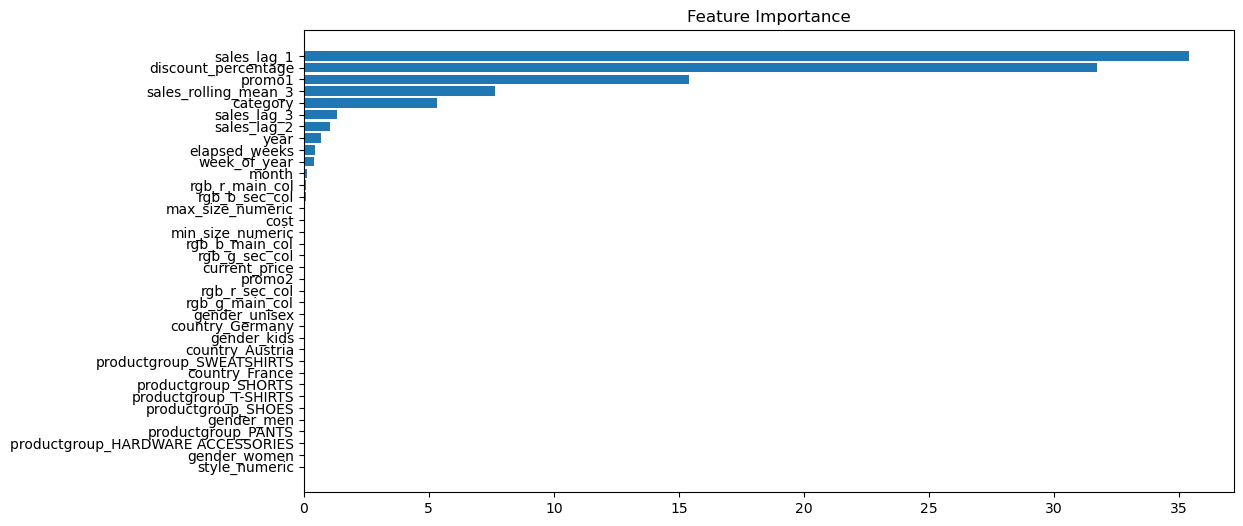

In [35]:
# Checking feature importance of new model with lagged features
feature_importance = best_model.feature_importances_

sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

## 4. Final discussion 
We can see from the feature importance graph that the new temporal features have the greatest importance when it comes to predicting future sales. This is to be expeted and, assuming we have the compuatational resources, could further motivate the use of other regression methods that naturally incorporate time series data (such as RNNs and LSTMs).

- LSTMs/RNNs
    - These architectures could also make use of the same methods that we have showcased in this notebook (such as Hyperparameter optimisation - in this case given enough time we could optimise things like learning and dropout rate as well as the choice of optimizer, the number of different parameters in each model layer and the activation functions).
    - The main advantage from a structural point of view is that these models naturally work with temporal (sequential) data. 
    - However, they suffer from compuational complexity due to their sequential training (we would likely require GPUs to create a viable model as well as larger datasets). On top of this they would also require workarounds to include the article characteristics which don't change over time. If we do not adjust the input layers to include these features at each step the model will only be able to incorporate previous sales data into the predictions.

- For further improvements of the current model (CatBoost) we could either:
    - Expand the search space for the Hyper Parameters
    - Perform additional feature engineering 
        - Create additioanl temporal features such as lagged promo0 and promo1/ lagged discounts
        - Transform the colour features (RGB) to to a format that is closer to what humans percieve (such as hue, saturation, brightness) or extract additional feautres such as the distance between the primary and secondary colour
    - Treat CatBoost as just one candidate model in an ensemble technique if certain types of errors in the predicted time series persist accross configurations.

Lastly, we note that the feature importance presented here is related to the predictive performance of the model and should not be confused for a measure of causal relationships between the available features and the sales numbers. If we wanted to measure the importance of a particular feature on the sales we would have to define our causal model (assumptions about the data generating process) and then estimate the effect on sales using the corresponding conditional expectations.